#**SMRTTECH 4AI3 Final Project**

Group: 6

Thomas French, Nicholas Grzelak

# Import Needed Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.models import Sequential,load_model
from keras.layers import InputLayer, Reshape, Conv2DTranspose, LeakyReLU, ReLU
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation
from keras.utils import plot_model
from keras.optimizers import Adam
import time

: 

#Make Custom Functions
**Define Discriminator**

In [9]:
def define_discriminator(in_shape,modname):
	model = Sequential(name=modname)
	model.add(Conv2D(32, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

**Define Generator**

In [10]:
def define_generator(latent_dim,modname):
	model = Sequential(name=modname)

	n_nodes = 128 * 8 * 8
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))

	model.add(Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2DTranspose(32, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

**Define GAN**

In [11]:
def define_gan(generator, discriminator,modname):

	discriminator.trainable = False

	model = Sequential(name=modname)
	model.add(generator)
	model.add(discriminator)

	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

**Define Getting Real Samples**

In [12]:
def generate_real_samples(dataset, n_samples):
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = np.ones((n_samples, 1))
	return X, y

**Define Getting AI Samples**

In [61]:
def generate_fake_samples(generator, latent_dim, n_samples):
  x_input = np.random.randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  #Normally verbose = 'auto'
  X = generator.predict(x_input,verbose = 0)
  y = np.zeros((n_samples, 1))
  return X, y

**Define Saving Plots**

In [14]:
def save_plot(examples, epoch, n=10):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

**Define Evaluator**

In [15]:
def evaluate(epoch, generator, discriminator, dataset, latent_dim, n_samples=100):
	X_real, y_real = generate_real_samples(dataset, n_samples)
	_, acc_real = discriminator.evaluate(X_real, y_real, verbose=0)

	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n_samples)
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)

	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

	save_plot(x_fake, epoch)
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	generator.save(filename)

**Define Loss Writer**

In [43]:
def writetxt(name,txtlist):
  f = open(name +".txt", "w+")
  for i in txtlist:
    f.write(str(i)+'\n')
  f.close()

#Training GAN
**Get Dataset**

In [16]:
#Download the dataset
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()

**Visualize Dataset**

In [ ]:
#Visualize the Dataset
class_names = ['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']

plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.gray)
    plt.xlabel(class_names[int(y_train[i])])
plt.show()

**Normalize Data**

In [17]:
#Normalize Data
train_images = x_train / 255.0
test_images = x_test / 255.0

**Hyperparameter Initalization**

In [34]:
batch_size = 100
n_epochs = 1000
bat_per_epo = int(train_images.shape[0] / batch_size)
half_batch = int(batch_size / 2)
latent_dim = 150

**Build Model**

In [63]:
#Build Discriminator
discriminator = define_discriminator((32,32,3),'discriminator')
discriminator.summary()

#Build Generator
generator = define_generator(100,'Generator')
generator.summary()

#Build GAN
gan = define_gan(generator, discriminator,'GAN')
gan.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 16, 16, 32)        896       
                                                                 
 leaky_re_lu_55 (LeakyReLU)  (None, 16, 16, 32)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 leaky_re_lu_56 (LeakyReLU)  (None, 8, 8, 64)          0         
                                                                 
 flatten_11 (Flatten)        (None, 4096)              0         
                                                                 
 dense_22 (Dense)            (None, 1)                 4097      
                                                                 
Total params: 23489 (91.75 KB)
Trainable params: 2348

**Train Model**

In [64]:
dlossavg = []
glossavg = []

start_time = time.time()

for i in range(n_epochs):
    print("Epoch: " + str(i))
    totaldloss = 0
    totalgloss = 0
    for j in range(batch_size):

      X_real, y_real = generate_real_samples(train_images, half_batch)
      X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
      X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
      d_loss, _ = discriminator.train_on_batch(X, y)

      X_gan = np.random.randn(latent_dim * batch_size)
      X_gan = X_gan.reshape(batch_size, latent_dim)
      y_gan = np.ones((batch_size, 1))
      g_loss = gan.train_on_batch(X_gan, y_gan)

      #print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

      totaldloss = totaldloss + d_loss
      totalgloss = totalgloss + g_loss

    totaldloss = totaldloss / (batch_size-1)
    totalgloss = totalgloss / (batch_size-1)

    dlossavg.append(totaldloss)
    glossavg.append(totalgloss)

    if (i+1) % 10 == 0:
      evaluate(i, generator, discriminator, train_images, latent_dim)
      writetxt("Gen_loss",glossavg)
      writetxt("Dis_loss",dlossavg)

end_time = time.time()

writetxt('Gen_loss',glossavg)
writetxt('Dis_loss',dlossavg)

print('Training Time', end_time-start_time)
print('First Values', dlossavg[0], glossavg[0])
print('Last Values', dlossavg[-1], glossavg[-1])

Epoch: 0
Epoch: 1
Training Time 48.53781199455261
First Values 0.6892522846915058 0.6649338848812064
Last Values 0.7194821269241805 0.736436745862371


#Test GAN

1/1 [==============================] - 0s 80ms/step


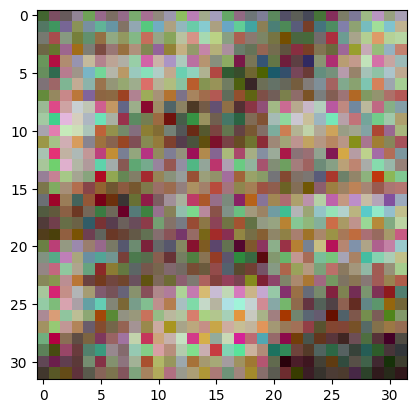

In [65]:
#model = load_model('generator_model_020.h5')
model = generator

vector = np.random.randn(100 * 1)
vector = vector.reshape(1, 100)

X = model.predict(vector)

plt.imshow(X[0, :, :, :])
plt.show()